In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [ ]:
os.listdir('/content')  # Check available files
df = pd.read_csv('/content/cicids2017_cleaned.csv')
print(df.head())

   Destination Port  Flow Duration  Total Fwd Packets  \
0                22        1266342                 41   
1                22        1319353                 41   
2                22            160                  1   
3                22        1303488                 41   
4             35396             77                  1   

   Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                         2664                    456                      0   
1                         2664                    456                      0   
2                            0                      0                      0   
3                         2728                    456                      0   
4                            0                      0                      0   

   Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  \
0               64.975610             109.864573                    976   
1               64.975610 

In [ ]:
df.info()  # Dataset summary
df = df.dropna()  # Drop missing values
print("Missing values after cleaning:", df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd IAT Total                int64  
 19  

In [ ]:
le = LabelEncoder()
df["Attack Type"] = le.fit_transform(df["Attack Type"])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Bots': np.int64(0), 'Brute Force': np.int64(1), 'DDoS': np.int64(2), 'DoS': np.int64(3), 'Normal Traffic': np.int64(4), 'Port Scanning': np.int64(5), 'Web Attacks': np.int64(6)}


In [ ]:
x = df.drop(columns=["Attack Type"])
y = df["Attack Type"]

<ipython-input-12-470fa37bc37a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


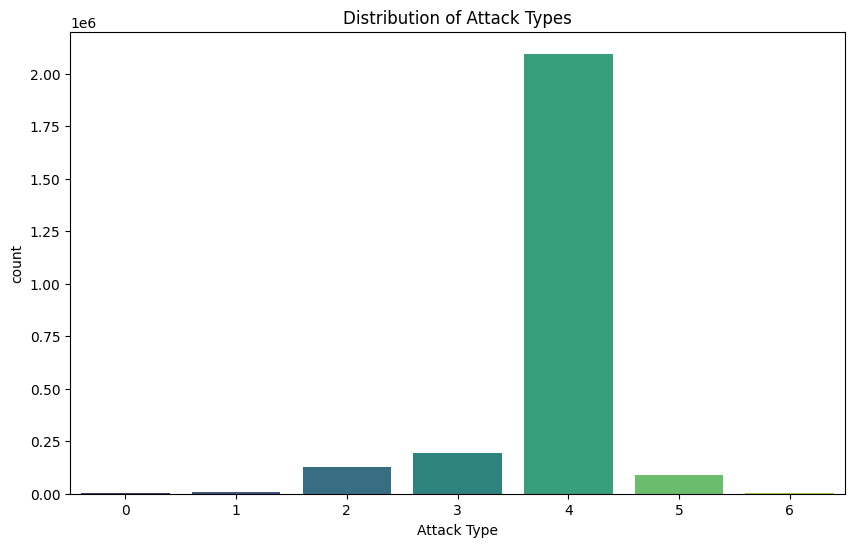

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y, palette="viridis")
plt.title("Distribution of Attack Types")
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [ ]:
y_train_pred = model.predict(x_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 1.0000


In [ ]:
y_pred = model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22761
           1       1.00      1.00      1.00     17564

    accuracy                           1.00     40325
   macro avg       1.00      1.00      1.00     40325
weighted avg       1.00      1.00      1.00     40325



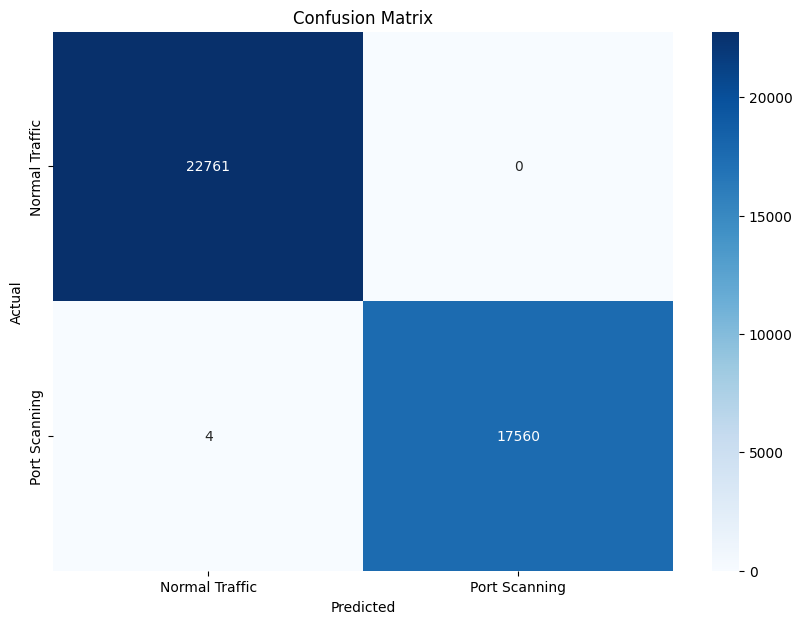

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

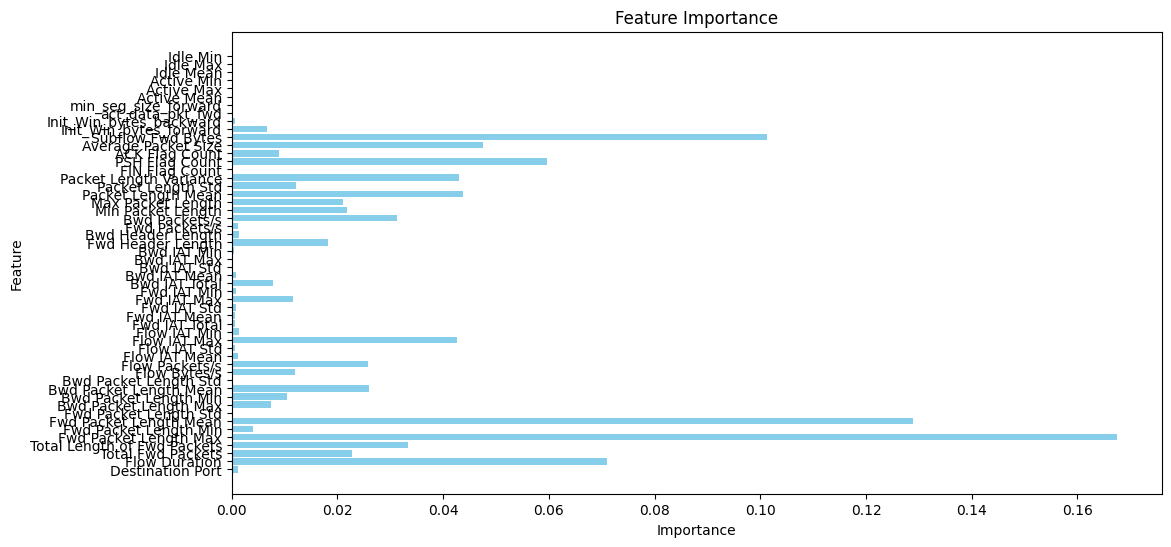

In [ ]:
feature_importance = model.feature_importances_
features = x.columns
plt.figure(figsize=(12, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [ ]:
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = model.predict_proba(x_test)

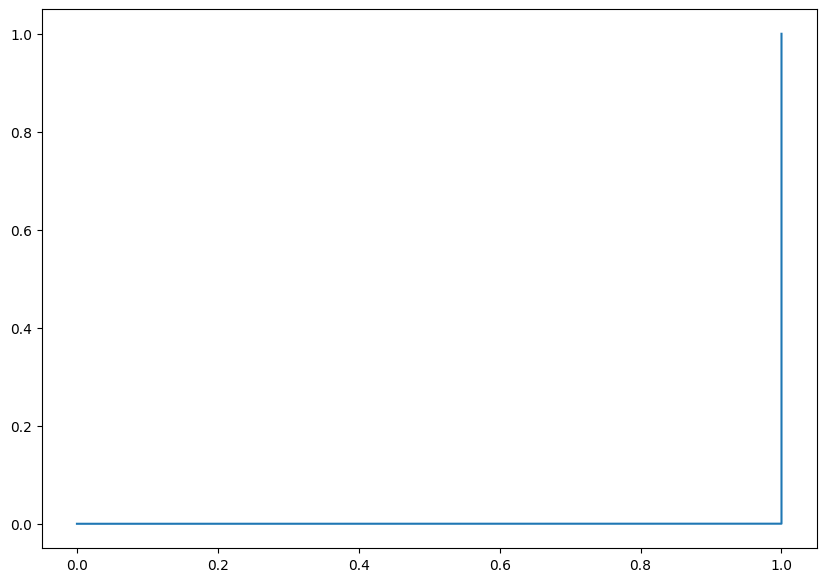

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')